In [5]:
import os
os.environ["FIFT_GL2D_DIR"] = "/n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d"

import pathlib, time, numpy as np, matplotlib.pyplot as plt
from fift import SIS, set_num_threads, FresnelNUFFT3Vec
from fift.compare_utils import plot_overlays_ws

from glow import lenses as glow_lenses
from glow import time_domain_c, freq_domain_c

set_num_threads(112)

def check_precomputed_gl_files(n_gl, Umax, directory):
    if not directory:
        raise RuntimeError("FIFT_GL2D_DIR is not set.")
    path_base = f"gl2d_n{n_gl}_U{int(Umax)}"
    required = [
        f"{path_base}.u1.npy",
        f"{path_base}.u2.npy",
        f"{path_base}.W.npy",
        f"{path_base}.meta.json"]
    missing = []
    for fname in required:
        if not pathlib.Path(directory, fname).exists():
            missing.append(fname)
    if missing:
        raise FileNotFoundError(
            f"The following precomputed GL2D files are missing in {directory}:\n  " + "\n  ".join(missing))
    else:
        print(f"All precomputed GL2D files found in {directory} for n={n_gl}, Umax={Umax}.\n")

def compare_plot_GLoW_FIFT(n_gl=1000, Umax=50, eps=1e-2,
                           lens   = SIS(psi0=1.0),
                           w_grid = np.logspace(-1.0, 1.0, 50),
                           y_star = 1.2,
                           shared_Umax=True):
    
    Xmax_shared = Umax
    fift_gl2d_dir = os.environ.get("FIFT_GL2D_DIR")

    check_precomputed_gl_files(n_gl, Umax, fift_gl2d_dir)

    t0 = time.perf_counter()
    nu3v = FresnelNUFFT3Vec(
        lens,
        n_gl=n_gl,
        Umax=Xmax_shared,
        eps=eps,
        shared_Umax=shared_Umax)
    F_fift = nu3v(w_grid, np.array([y_star]), np.array([0.0]))[:, 0]
    
    # from threadpoolctl import threadpool_limits
    # with threadpool_limits(limits=1, user_api='blas'):
    #     F_fift = nu3v(w_grid, np.array([y_star]), np.array([0.0]))[:, 0]

    
    t1 = time.perf_counter()
    fift_s = t1 - t0

    t2 = time.perf_counter()
    Psi = glow_lenses.Psi_SIS({'psi0': 1.0}, {})
    It  = time_domain_c.It_MultiContour_C(Psi, y=y_star)
    Fw  = freq_domain_c.Fw_FFT_C(It)
    F_glow = Fw(w_grid)
    t3 = time.perf_counter()
    glow_s = t3 - t2

    plot_overlays_ws(w_grid, F_fift, F_glow, n_gl, Umax, title=f"SIS @ y={y_star}", align_phase=True)

    print(f"FIFT time (single run): {fift_s:.4f} s")
    print(f"GLoW time (single run): {glow_s:.4f} s")
    print(f"Speedup (GLoW/FIFT): {glow_s/fift_s:.2f}×")


# Changing $n_{\text{gl}}$

For a fixed (reasonable) integration domain, increasing the number of nodes improves our accuracy, as expected.

In particular, the numerical error reduces for the low frequencies. The higher the $N_{\text{gl}}$, the lower $\omega$'s we can probe.

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=100, Umax=50.

[coeffs] avg 8.41 cores over 0.602s (7.5% of 112 logical cores; CPU sec=5.063)
[nufft] avg 58.61 cores over 0.185s (52.3% of 112 logical cores; CPU sec=10.857)
[timing] 1. quadrature setup:        0.010901 s
[timing] 2. scales/phases/coeffs:    0.602685 s
[timing] 3. NUFFT:                   0.185616 s
[timing] 4. quad_phase+alloc:        0.000082 s
[timing] 5. final loop:              0.000399 s
[timing] total:                      0.799684 s


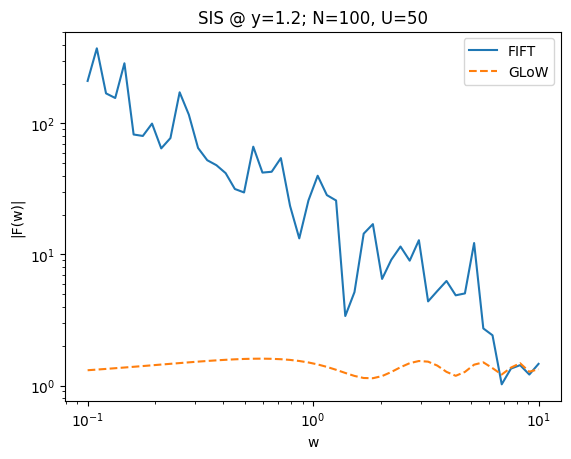

FIFT time (single run): 0.8017 s
GLoW time (single run): 0.0543 s
Speedup (GLoW/FIFT): 0.07×


In [2]:
compare_plot_GLoW_FIFT(n_gl=100, Umax=50, eps=1e-13, shared_Umax=True)

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=250, Umax=50.

[coeffs] avg 6.77 cores over 0.991s (6.0% of 112 logical cores; CPU sec=6.705)
[nufft] avg 57.99 cores over 0.152s (51.8% of 112 logical cores; CPU sec=8.808)
[timing] 1. quadrature setup:        0.004672 s
[timing] 2. scales/phases/coeffs:    0.991472 s
[timing] 3. NUFFT:                   0.152406 s
[timing] 4. quad_phase+alloc:        0.000124 s
[timing] 5. final loop:              0.000636 s
[timing] total:                      1.149310 s


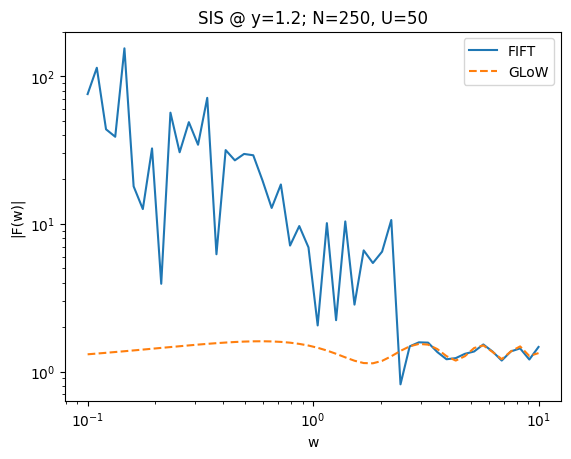

FIFT time (single run): 1.1579 s
GLoW time (single run): 0.0191 s
Speedup (GLoW/FIFT): 0.02×


In [3]:
compare_plot_GLoW_FIFT(n_gl=250, Umax=50, eps=1e-13, shared_Umax=True)

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=500, Umax=50.

[coeffs] avg 4.55 cores over 1.983s (4.1% of 112 logical cores; CPU sec=9.019)
[nufft] avg 53.11 cores over 0.235s (47.4% of 112 logical cores; CPU sec=12.463)
[timing] 1. quadrature setup:        0.005298 s
[timing] 2. scales/phases/coeffs:    1.983478 s
[timing] 3. NUFFT:                   0.235174 s
[timing] 4. quad_phase+alloc:        0.000097 s
[timing] 5. final loop:              0.000304 s
[timing] total:                      2.224352 s


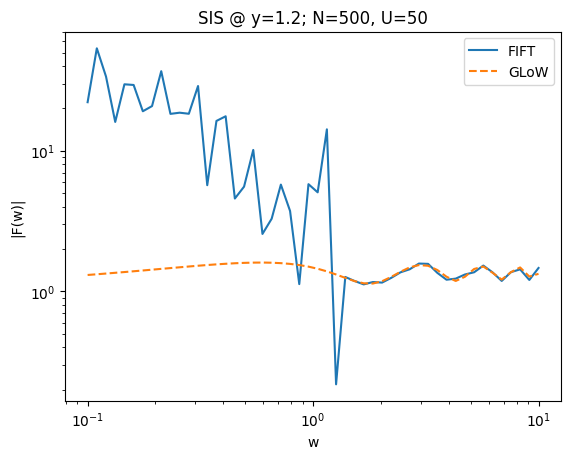

FIFT time (single run): 2.2453 s
GLoW time (single run): 0.0201 s
Speedup (GLoW/FIFT): 0.01×


In [4]:
compare_plot_GLoW_FIFT(n_gl=500, Umax=50, eps=1e-13, shared_Umax=True)

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=1000, Umax=50.

[coeffs] avg 3.23 cores over 5.312s (2.9% of 112 logical cores; CPU sec=17.134)
[nufft] avg 38.42 cores over 0.529s (34.3% of 112 logical cores; CPU sec=20.340)
[timing] 1. quadrature setup:        0.006814 s
[timing] 2. scales/phases/coeffs:    5.313384 s
[timing] 3. NUFFT:                   0.530196 s
[timing] 4. quad_phase+alloc:        0.000570 s
[timing] 5. final loop:              0.000403 s
[timing] total:                      5.851367 s


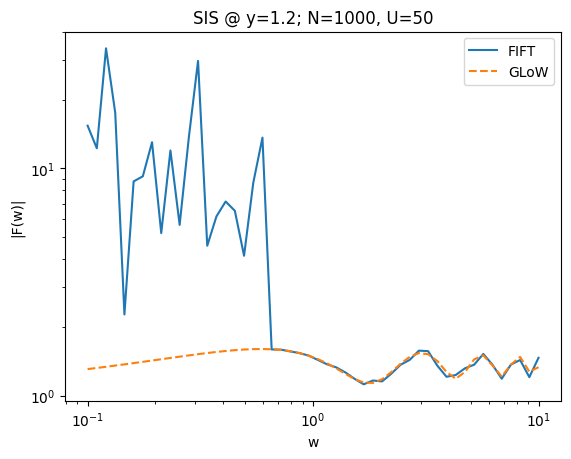

FIFT time (single run): 5.8725 s
GLoW time (single run): 0.0204 s
Speedup (GLoW/FIFT): 0.00×


In [5]:
compare_plot_GLoW_FIFT(n_gl=1000, Umax=50, eps=1e-13, shared_Umax=True)

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=4000, Umax=50.

[coeffs] avg 2.88 cores over 58.141s (2.6% of 112 logical cores; CPU sec=167.559)
[nufft] avg 33.21 cores over 5.207s (29.7% of 112 logical cores; CPU sec=172.932)
[timing] 1. quadrature setup:        0.004840 s
[timing] 2. scales/phases/coeffs:    58.141208 s
[timing] 3. NUFFT:                   5.207107 s
[timing] 4. quad_phase+alloc:        0.000075 s
[timing] 5. final loop:              0.000274 s
[timing] total:                      63.353504 s


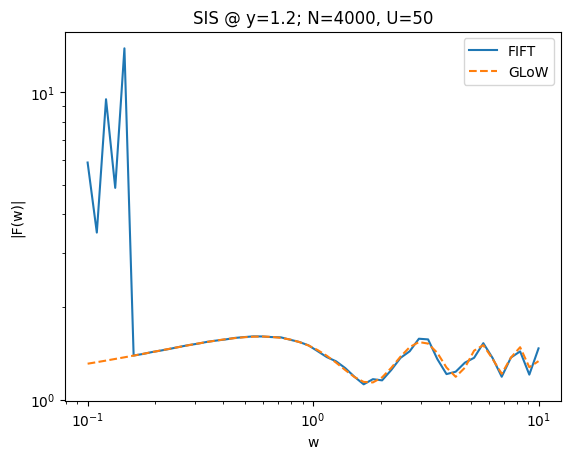

FIFT time (single run): 63.4252 s
GLoW time (single run): 0.0469 s
Speedup (GLoW/FIFT): 0.00×


In [6]:
compare_plot_GLoW_FIFT(n_gl=4000, Umax=50, eps=1e-13, shared_Umax=True)

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=8000, Umax=50.

[coeffs] avg 2.85 cores over 186.711s (2.5% of 112 logical cores; CPU sec=532.636)
[nufft] avg 26.68 cores over 17.350s (23.8% of 112 logical cores; CPU sec=462.866)
[timing] 1. quadrature setup:        0.003088 s
[timing] 2. scales/phases/coeffs:    186.712048 s
[timing] 3. NUFFT:                   17.351062 s
[timing] 4. quad_phase+alloc:        0.000275 s
[timing] 5. final loop:              0.000702 s
[timing] total:                      204.067175 s


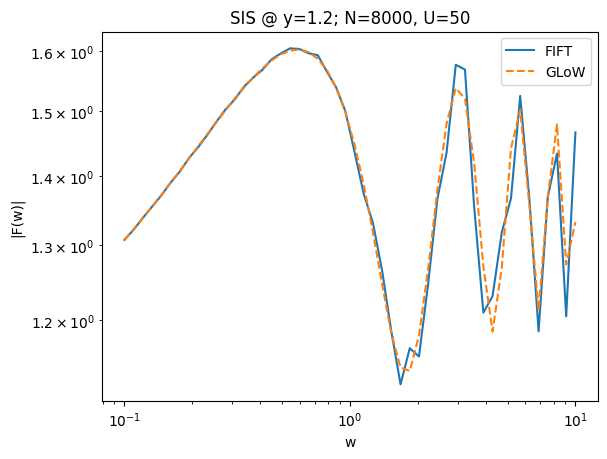

FIFT time (single run): 204.3245 s
GLoW time (single run): 0.0196 s
Speedup (GLoW/FIFT): 0.00×


In [7]:
compare_plot_GLoW_FIFT(n_gl=8000, Umax=50, eps=1e-13, shared_Umax=True)

# Changing $U_{\text{max}}$

## Fixing $N_{\text{gl}} = 500$

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=500, Umax=10.

[coeffs] avg 4.22 cores over 2.311s (3.8% of 112 logical cores; CPU sec=9.763)
[nufft] avg 57.26 cores over 0.247s (51.1% of 112 logical cores; CPU sec=14.135)
[timing] 1. quadrature setup:        0.006072 s
[timing] 2. scales/phases/coeffs:    2.311707 s
[timing] 3. NUFFT:                   0.247235 s
[timing] 4. quad_phase+alloc:        0.000110 s
[timing] 5. final loop:              0.000628 s
[timing] total:                      2.565752 s


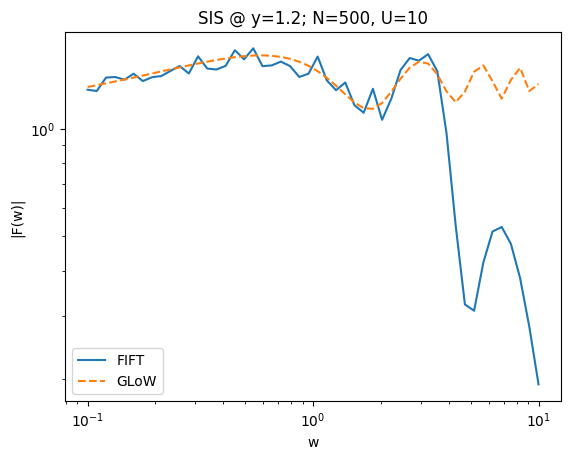

FIFT time (single run): 2.5721 s
GLoW time (single run): 0.0539 s
Speedup (GLoW/FIFT): 0.02×


In [8]:
compare_plot_GLoW_FIFT(n_gl=500, Umax=10, eps=1e-13, shared_Umax=True)

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=500, Umax=15.

[coeffs] avg 5.09 cores over 1.653s (4.5% of 112 logical cores; CPU sec=8.415)
[nufft] avg 56.63 cores over 0.204s (50.6% of 112 logical cores; CPU sec=11.544)
[timing] 1. quadrature setup:        0.002982 s
[timing] 2. scales/phases/coeffs:    1.653898 s
[timing] 3. NUFFT:                   0.204076 s
[timing] 4. quad_phase+alloc:        0.000062 s
[timing] 5. final loop:              0.000256 s
[timing] total:                      1.861274 s


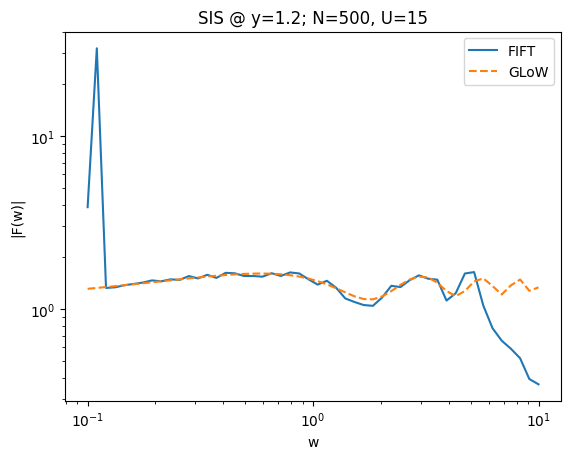

FIFT time (single run): 1.8676 s
GLoW time (single run): 0.0473 s
Speedup (GLoW/FIFT): 0.03×


In [9]:
compare_plot_GLoW_FIFT(n_gl=500, Umax=15, eps=1e-13, shared_Umax=True)

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=500, Umax=20.

[coeffs] avg 5.84 cores over 1.446s (5.2% of 112 logical cores; CPU sec=8.443)
[nufft] avg 60.06 cores over 0.250s (53.6% of 112 logical cores; CPU sec=14.993)
[timing] 1. quadrature setup:        0.002869 s
[timing] 2. scales/phases/coeffs:    1.446840 s
[timing] 3. NUFFT:                   0.249947 s
[timing] 4. quad_phase+alloc:        0.000080 s
[timing] 5. final loop:              0.000262 s
[timing] total:                      1.699998 s


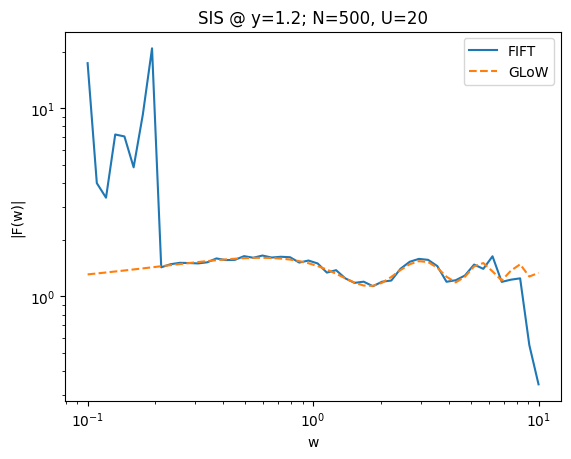

FIFT time (single run): 1.7065 s
GLoW time (single run): 0.0156 s
Speedup (GLoW/FIFT): 0.01×


In [10]:
compare_plot_GLoW_FIFT(n_gl=500, Umax=20, eps=1e-13, shared_Umax=True)

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=500, Umax=25.

[coeffs] avg 4.92 cores over 1.706s (4.4% of 112 logical cores; CPU sec=8.393)
[nufft] avg 61.48 cores over 0.240s (54.9% of 112 logical cores; CPU sec=14.758)
[timing] 1. quadrature setup:        0.004655 s
[timing] 2. scales/phases/coeffs:    1.706487 s
[timing] 3. NUFFT:                   0.240281 s
[timing] 4. quad_phase+alloc:        0.000058 s
[timing] 5. final loop:              0.000250 s
[timing] total:                      1.951730 s


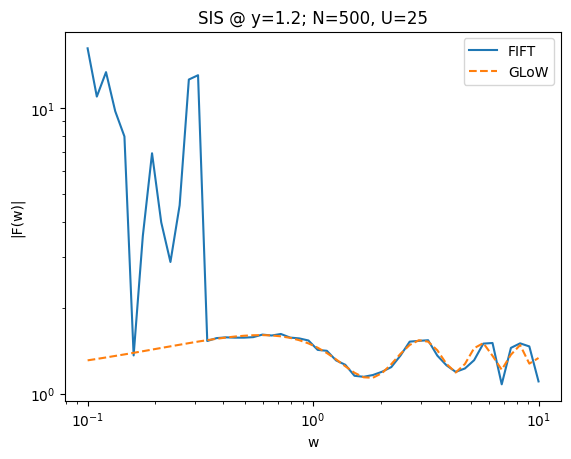

FIFT time (single run): 1.9631 s
GLoW time (single run): 0.0598 s
Speedup (GLoW/FIFT): 0.03×


In [11]:
compare_plot_GLoW_FIFT(n_gl=500, Umax=25, eps=1e-13, shared_Umax=True)

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=500, Umax=50.

[coeffs] avg 4.86 cores over 1.621s (4.3% of 112 logical cores; CPU sec=7.887)
[nufft] avg 51.50 cores over 0.204s (46.0% of 112 logical cores; CPU sec=10.509)
[timing] 1. quadrature setup:        0.004223 s
[timing] 2. scales/phases/coeffs:    1.621943 s
[timing] 3. NUFFT:                   0.204525 s
[timing] 4. quad_phase+alloc:        0.000146 s
[timing] 5. final loop:              0.000626 s
[timing] total:                      1.831462 s


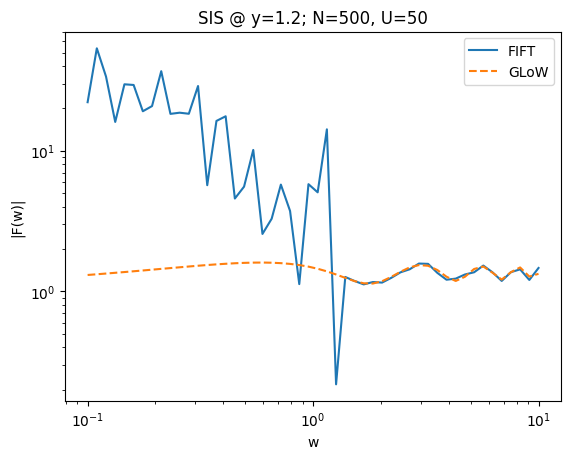

FIFT time (single run): 1.8464 s
GLoW time (single run): 0.0633 s
Speedup (GLoW/FIFT): 0.03×


In [12]:
compare_plot_GLoW_FIFT(n_gl=500, Umax=50, eps=1e-13, shared_Umax=True)

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=1000, Umax=100.

[coeffs] avg 3.61 cores over 5.952s (3.2% of 112 logical cores; CPU sec=21.509)
[nufft] avg 37.23 cores over 0.459s (33.2% of 112 logical cores; CPU sec=17.080)
[timing] 1. quadrature setup:        0.008715 s
[timing] 2. scales/phases/coeffs:    5.952972 s
[timing] 3. NUFFT:                   0.459586 s
[timing] 4. quad_phase+alloc:        0.000106 s
[timing] 5. final loop:              0.000320 s
[timing] total:                      6.421700 s


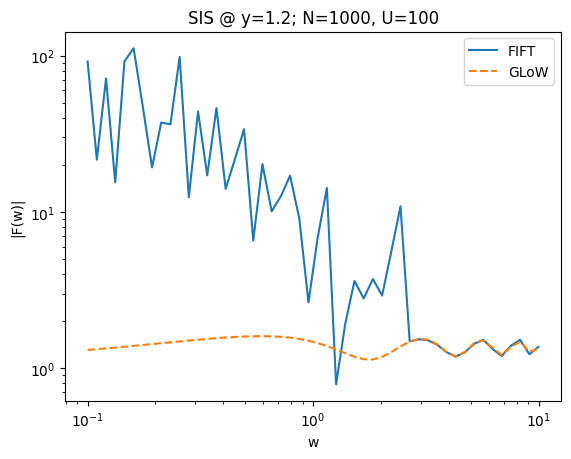

FIFT time (single run): 6.4460 s
GLoW time (single run): 0.0645 s
Speedup (GLoW/FIFT): 0.01×


In [13]:
compare_plot_GLoW_FIFT(n_gl=1000, Umax=100, eps=1e-13, shared_Umax=True)

## Fixing $N_{\text{gl}} = 4000$

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=4000, Umax=20.

[coeffs] avg 3.45 cores over 54.809s (3.1% of 112 logical cores; CPU sec=189.341)
[nufft] avg 33.18 cores over 5.156s (29.6% of 112 logical cores; CPU sec=171.086)
[timing] 1. quadrature setup:        0.006266 s
[timing] 2. scales/phases/coeffs:    54.809256 s
[timing] 3. NUFFT:                   5.156468 s
[timing] 4. quad_phase+alloc:        0.000091 s
[timing] 5. final loop:              0.000282 s
[timing] total:                      59.972363 s


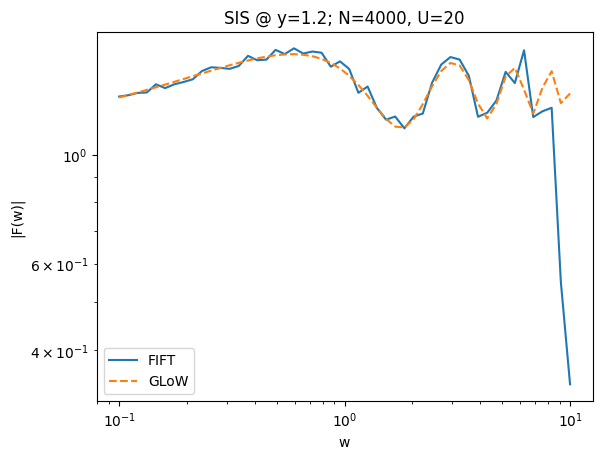

FIFT time (single run): 60.0421 s
GLoW time (single run): 0.0216 s
Speedup (GLoW/FIFT): 0.00×


In [15]:
compare_plot_GLoW_FIFT(n_gl=4000, Umax=20, eps=1e-13, shared_Umax=True)

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=4000, Umax=30.

[coeffs] avg 3.37 cores over 40.862s (3.0% of 112 logical cores; CPU sec=137.781)
[nufft] avg 33.43 cores over 5.050s (29.8% of 112 logical cores; CPU sec=168.834)
[timing] 1. quadrature setup:        0.003453 s
[timing] 2. scales/phases/coeffs:    40.862331 s
[timing] 3. NUFFT:                   5.050629 s
[timing] 4. quad_phase+alloc:        0.000076 s
[timing] 5. final loop:              0.000277 s
[timing] total:                      45.916766 s


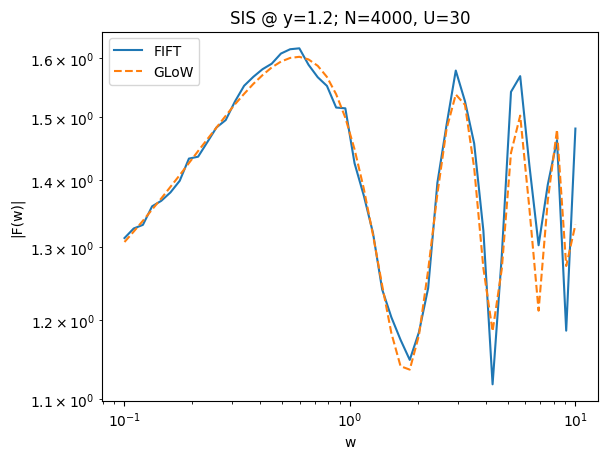

FIFT time (single run): 45.9895 s
GLoW time (single run): 0.0143 s
Speedup (GLoW/FIFT): 0.00×


In [16]:
compare_plot_GLoW_FIFT(n_gl=4000, Umax=30, eps=1e-13, shared_Umax=True)

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=4000, Umax=40.

[coeffs] avg 3.62 cores over 36.077s (3.2% of 112 logical cores; CPU sec=130.558)
[nufft] avg 33.30 cores over 5.108s (29.7% of 112 logical cores; CPU sec=170.111)
[timing] 1. quadrature setup:        0.003633 s
[timing] 2. scales/phases/coeffs:    36.077776 s
[timing] 3. NUFFT:                   5.108930 s
[timing] 4. quad_phase+alloc:        0.000149 s
[timing] 5. final loop:              0.000213 s
[timing] total:                      41.190702 s


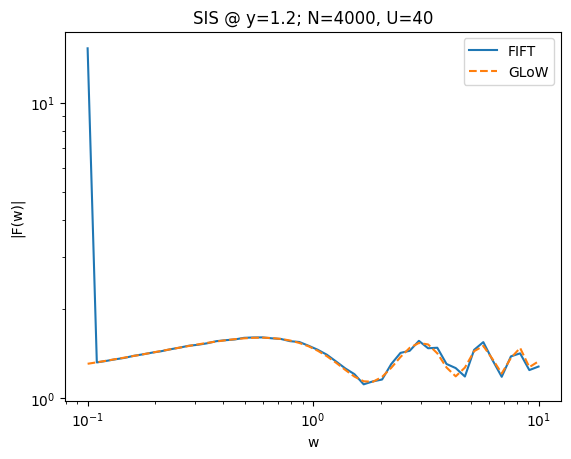

FIFT time (single run): 41.2512 s
GLoW time (single run): 0.0480 s
Speedup (GLoW/FIFT): 0.00×


In [17]:
compare_plot_GLoW_FIFT(n_gl=4000, Umax=40, eps=1e-13, shared_Umax=True)

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=4000, Umax=50.

[coeffs] avg 3.32 cores over 43.543s (3.0% of 112 logical cores; CPU sec=144.586)
[nufft] avg 33.96 cores over 5.095s (30.3% of 112 logical cores; CPU sec=173.044)
[timing] 1. quadrature setup:        0.003813 s
[timing] 2. scales/phases/coeffs:    43.543795 s
[timing] 3. NUFFT:                   5.095725 s
[timing] 4. quad_phase+alloc:        0.000102 s
[timing] 5. final loop:              0.000285 s
[timing] total:                      48.643720 s


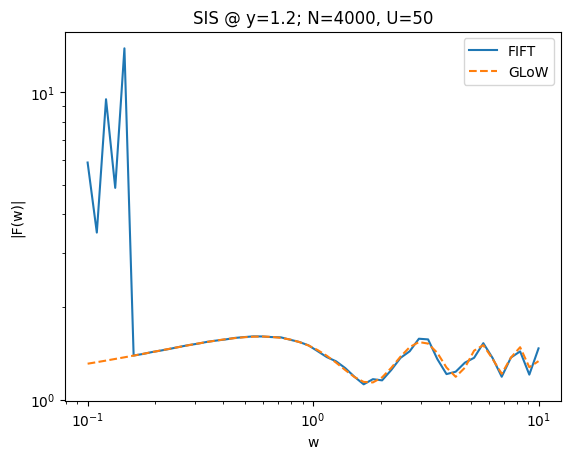

FIFT time (single run): 48.7127 s
GLoW time (single run): 0.0139 s
Speedup (GLoW/FIFT): 0.00×


In [18]:
compare_plot_GLoW_FIFT(n_gl=4000, Umax=50, eps=1e-13, shared_Umax=True)

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=4000, Umax=100.

[coeffs] avg 3.38 cores over 53.050s (3.0% of 112 logical cores; CPU sec=179.325)
[nufft] avg 33.63 cores over 5.085s (30.0% of 112 logical cores; CPU sec=171.029)
[timing] 1. quadrature setup:        0.006248 s
[timing] 2. scales/phases/coeffs:    53.050889 s
[timing] 3. NUFFT:                   5.085385 s
[timing] 4. quad_phase+alloc:        0.000071 s
[timing] 5. final loop:              0.000288 s
[timing] total:                      58.142881 s


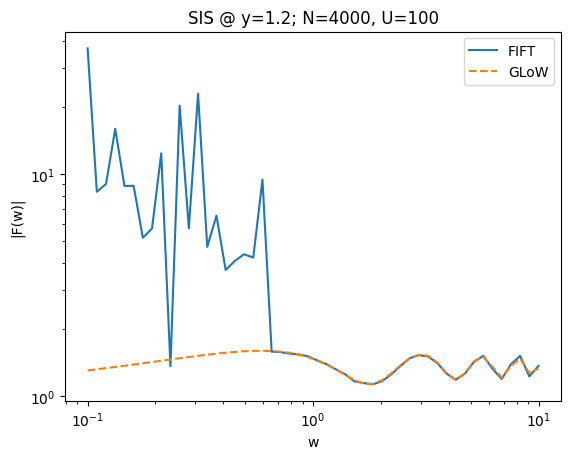

FIFT time (single run): 58.2108 s
GLoW time (single run): 0.0130 s
Speedup (GLoW/FIFT): 0.00×


In [19]:
compare_plot_GLoW_FIFT(n_gl=4000, Umax=100, eps=1e-13, shared_Umax=True)

All precomputed GL2D files found in /n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d for n=4000, Umax=200.

[coeffs] avg 3.34 cores over 51.536s (3.0% of 112 logical cores; CPU sec=171.974)
[nufft] avg 33.80 cores over 5.095s (30.2% of 112 logical cores; CPU sec=172.193)
[timing] 1. quadrature setup:        0.006907 s
[timing] 2. scales/phases/coeffs:    51.536723 s
[timing] 3. NUFFT:                   5.095329 s
[timing] 4. quad_phase+alloc:        0.000088 s
[timing] 5. final loop:              0.000287 s
[timing] total:                      56.639335 s


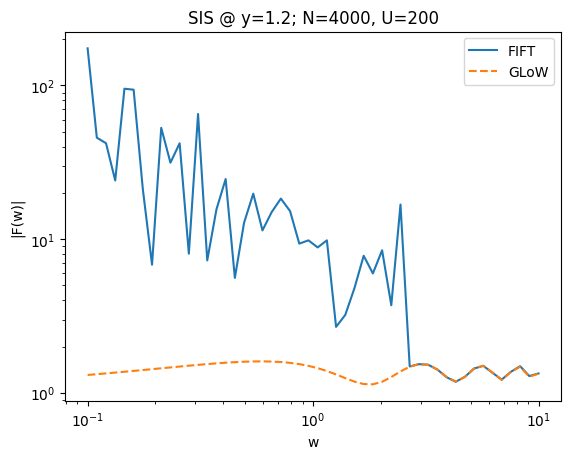

FIFT time (single run): 56.7069 s
GLoW time (single run): 0.0130 s
Speedup (GLoW/FIFT): 0.00×


In [20]:
compare_plot_GLoW_FIFT(n_gl=4000, Umax=200, eps=1e-13, shared_Umax=True)